In [42]:
from matplotlib import pyplot as plt
import heapq as pq
import re
import numpy as np
import math
from PIL import Image

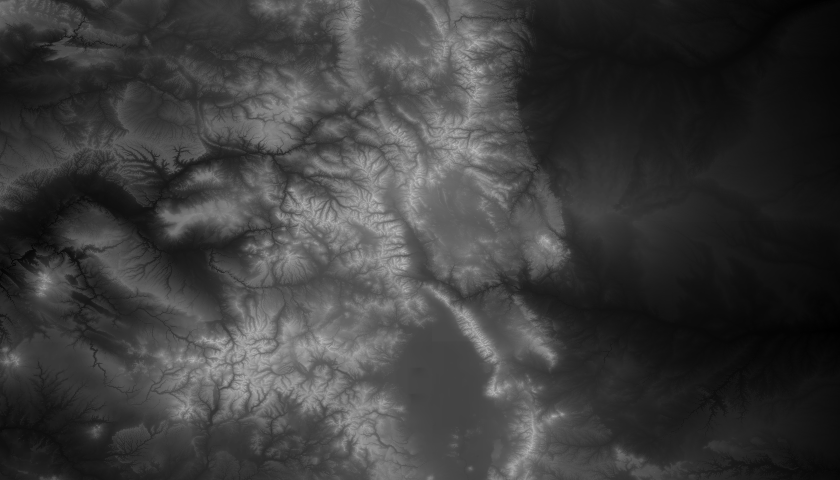

In [43]:
def get_img():
  with open("Colorado_844x480.dat") as f:
    s = f.read()
  s = [int(i) for i in re.split("\s+", s)[1:]]
  arr = []
  for i in range(0, len(s), 840):
    arr.append(s[i:i+840])
  arr = np.array(arr)
  highest = arr.max()
  lowest = arr.min()
  scaled = (arr - lowest) / highest * 255
  image = Image.fromarray(scaled)
  image = image.convert("RGB")
  scaled_rgb = np.array(image)
  return image, scaled_rgb, arr
image, scaled_rgb, arr = get_img()
image

In [44]:
class TileWrapper:

  def __init__(self, r, c, value):
    self.r = r
    self.c = c
    self.value = value
  
  def __le__(self, other):
    return (self.value) <= (other.value)
  
  def __ge__(self, other):
    return self.value >= other.value
  
  def __lt__(self, other):
    return self.value < other.value
  
  def __gt__(self, other):
    return self.value > other.value
  
  def __eq__(self, other):
    return self.r == other.r and self.c == other.c

In [45]:
def neighbors(r, c):
  potential = [(r - 1, c - 1), (r - 1, c), (r - 1, c + 1),
               (r, c - 1), (r, c + 1),
               (r + 1, c - 1), (r + 1, c), (r + 1, c + 1)
               ]
  ans = []
  for i in potential:
    if not ((-1 in i) or i[0] == 480 or i[1] == 840):
      ans.append(i)
  return ans

In [65]:
heuristic = lambda curr, dest : 0#25 * math.sqrt((curr[0] - dest[0]) ** 2 + (curr[1] - dest[1]) ** 2)
dist = lambda a, b : abs(arr[a[0], a[1]] - arr[b[0], b[1]])
# Start as (r, c) tuple, heuristic takes (r, c) tuple
def a_star(start, stop):
  visited = []
  visiteds = []
  open = [TileWrapper(*start, heuristic(start, stop))]
  g = {start : 0}
  h = {start : heuristic(start, stop)}
  values = {start : heuristic(start, stop)}
  cameFrom = {start : None}
  open_set = set()
  open_set.add(start)
  while open:
    current = pq.heappop(open) # this is O(log(n)) instead of looping through an array
    current = (current.r, current.c)
    open_set.remove(current)
    visited.append(current)
    if len(visited) >= 200:
      visiteds.append(visited)
      visited = []
    if current == stop:
      visiteds.append(visited)
      return reconstruct_path(stop, cameFrom), visiteds
    for neighbor in neighbors(*current):
      tentative_g = g[current] + dist(current, neighbor)
      if tentative_g < g.get(neighbor, math.inf):
        cameFrom[neighbor] = current
        g[neighbor] = tentative_g
        values[neighbor] = tentative_g + heuristic(neighbor, stop)
        if neighbor not in open_set: # this is O(1) instead of looping through an array
          pq.heappush(open, TileWrapper(*neighbor, values[neighbor]))
          open_set.add(neighbor)
  return None


In [52]:
def reconstruct_path(stop, cameFrom):
  path = [stop]
  while stop is not None:
    stop = cameFrom[stop]
    path.append(stop)
  return path[:-1][::-1]

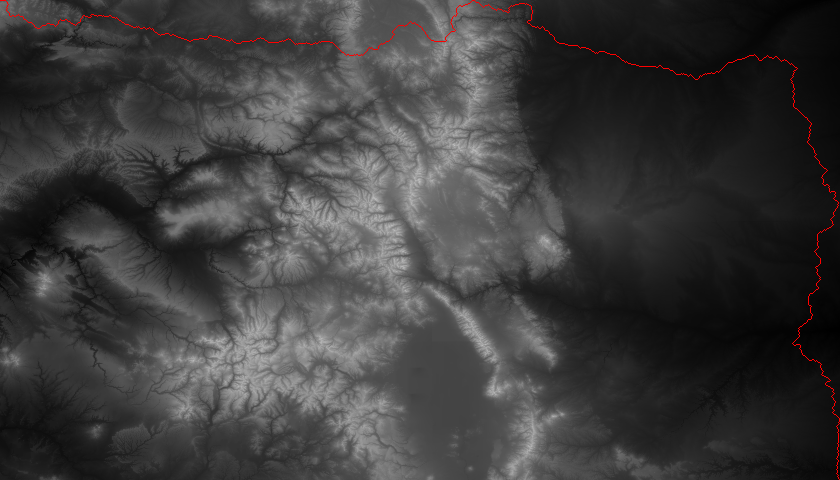

In [66]:
image, scaled_rgb, arr = get_img()
def plot_path(img_data, path):
  for point in path:
    img_data[point] = (255, 0, 0)

def add_visited(img_data, visited):
  for point in visited:
    if not img_data[point[0], point[1], 1] == 0:
     img_data[point[0], point[1]] = (scaled_rgb[point[0], point[1], 0], 0, 0)

path, visiteds = a_star((0, 0), (479, 839))
# use this code to generate a GIF that shows which cells the algorithm checks
"""frame_data = scaled_rgb.copy()
frames = []
for i in visiteds:
  add_visited(frame_data, i)
  frames.append(frame_data.copy())
for i in range(len(frames)):
  frames[i] = Image.fromarray(frames[i])
print(len(frames))
frames[0].save("out_opt.gif", save_all=True, append_images=frames[1:], format="GIF", duration=40)"""

# use this code to show the final path the algorithm decides on
plot_path(scaled_rgb, path)
Image.fromarray(scaled_rgb)

